# **MLProcess - Air Quality**
---
2 - Data Understanding (EDA)

In [1]:
# Import the required libraries.
import yaml
import joblib
import numpy as np
import pandas as pd

# Need to be installed.
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt

## **1 - Configuration File**
---

In [2]:
def load_config(config_path):
    """
    Load the configuration file (config.yaml).

    Parameters:
    ----------
    config_path : str
        Configuration file location.

    Returns:
    -------
    params : dict
        The configuration parameters.
    """

    # Try to load config.yaml file.
    try:
        with open(config_path, 'r') as file:
            params = yaml.safe_load(file)
    except FileNotFoundError as err:
        raise RuntimeError(f"Configuration file not found in {config_path}")

    return params

In [3]:
# Load the configuration file.
PATH_CONFIG = "../config/config.yaml"
config = load_config(PATH_CONFIG)

In [4]:
config

{'datetime_columns': ['tanggal'],
 'features': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'category',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'object_columns': ['stasiun', 'critical', 'category'],
 'path_joined_data': '../data/interim/joined_dataset.pkl',
 'path_raw_data': '../data/raw/',
 'path_test_set': ['../data/interim/X_test.pkl', '../data/interim/y_test.pkl'],
 'path_train_set': ['../data/interim/X_train.pkl',
  '../data/interim/y_train.pkl'],
 'path_valid_set': ['../data/interim/X_valid.pkl',
  '../data/interim/y_valid.pkl'],
 'path_validated_data': '../data/interim/validated_data.pkl',
 'range_co': [-1, 47],
 'range_no2': [-1, 65],
 'range_o3': [-1, 151],
 'range_pm10': [-1, 179],
 'range_pm25': [-1, 174],
 'range_so2': [-1, 82],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DK

## **2 - Load Data**
---
Note: Do EDA only on the train set.

In [5]:
# Load the train set.
X_train = joblib.load(config["path_train_set"][0])
y_train = joblib.load(config["path_train_set"][1])

In [6]:
# Join X_train and y_train.
dataset = pd.concat(
    [X_train, y_train],
    axis = 1
)

In [7]:
# Check the joined train set.
dataset

,stasiun,pm10,pm25,so2,co,o3,no2,category
235,DKI3 (Jagakarsa),-1,86,49,11,29,1,SEDANG
1671,DKI5 (Kebon Jeruk) Jakarta Barat,58,90,30,19,21,31,SEDANG
1049,DKI5 (Kebon Jeruk) Jakarta Barat,54,88,31,12,17,28,SEDANG
401,DKI3 (Jagakarsa),46,13,16,10,41,4,BAIK
1110,DKI2 (Kelapa Gading),79,102,55,14,30,29,TIDAK SEHAT
...,...,...,...,...,...,...,...,...
144,DKI5 (Kebon Jeruk) Jakarta Barat,58,89,32,10,31,24,SEDANG
1331,DKI4 (Lubang Buaya),24,55,41,10,18,8,SEDANG
1451,DKI3 (Jagakarsa),42,65,51,7,36,10,SEDANG
201,DKI2 (Kelapa Gading),52,-1,50,9,52,-1,SEDANG


## **3 - Exploratory Data Analysis**
---
1. Missing Value Check
2. Skewness Check
3. Data Split
4. Visualization
5. Hypothesis Test
6. Imbalanced Label Check
7. Outliers Check

### **3.1. Missing Value Check**

In [8]:
# Replace the -1 values with NaN.
dataset = dataset.replace(-1, np.nan)

In [9]:
# Check the number of missing values.
dataset.isnull().sum()

stasiun      0
pm10        42
pm25        69
so2         76
co          12
o3          38
no2         14
category     0
dtype: int64

### **3.2. Skewness Check**

In [10]:
# Fisher-Pearson Skew values.
dataset.skew(numeric_only=True)

pm10    0.175463
pm25    0.264545
so2     0.131270
co      1.775093
o3      1.601345
no2     0.872154
dtype: float64

**Insights:**
- All variables are right skewed, but pm10, pm25, and so2 are not significantly skewed.
- co, o3, and no2 have skew values $> 0.5$, indicating a lot of outliers. We will impute using it's median.
- The rest will be imputed using it's mean.

### **3.3. Data Split**
---
Split the data by it's class.

In [11]:
dataset_baik = dataset[dataset["category"] == "BAIK"].copy()
dataset_tidak_baik = dataset[dataset["category"] != "BAIK"].copy()

In [12]:
# Kelas 1 => BAIK.
dataset_baik.describe()

,pm10,pm25,so2,co,o3,no2
count,144.000000,109.000000,146.000000,151.000000,148.000000,143.000000
mean,28.944444,39.559633,24.753425,9.132450,26.054054,11.209790
std,8.038176,9.019969,10.711619,4.402538,11.156148,6.522824
min,14.000000,13.000000,3.000000,2.000000,7.000000,3.000000
25%,23.000000,34.000000,17.000000,7.000000,16.000000,6.000000
50%,28.000000,41.000000,22.000000,8.000000,24.000000,10.000000
75%,33.000000,47.000000,31.750000,11.000000,36.000000,15.000000
max,50.000000,50.000000,50.000000,28.000000,48.000000,49.000000


In [13]:
# Kelas 0 => SEDANG & TIDAK SEHAT
dataset_tidak_baik.describe()

,pm10,pm25,so2,co,o3,no2
count,1264.000000,1272.000000,1228.000000,1287.000000,1264.000000,1293.000000
mean,55.615506,82.725629,36.266287,11.930847,32.674051,20.220418
std,13.021790,22.134082,12.273437,4.917582,14.837940,8.787929
min,19.000000,19.000000,2.000000,3.000000,9.000000,1.000000
25%,49.000000,68.000000,27.000000,9.000000,23.000000,14.000000
50%,56.000000,81.000000,37.000000,11.000000,29.000000,19.000000
75%,64.000000,96.000000,45.000000,14.000000,38.250000,25.000000
max,179.000000,174.000000,81.000000,44.000000,151.000000,65.000000


**Insights:**

- pm10 and pm25 mean between class 0 and 1 have a significant difference. We will impute using class mean.
- so2 mean between class 0 and 1 have a slight difference. We will be impute using the mean.
- co, o3, and no2 median between class 0 and 1 have a slight difference. We will impute using the median.

### **3.4. Visualization**

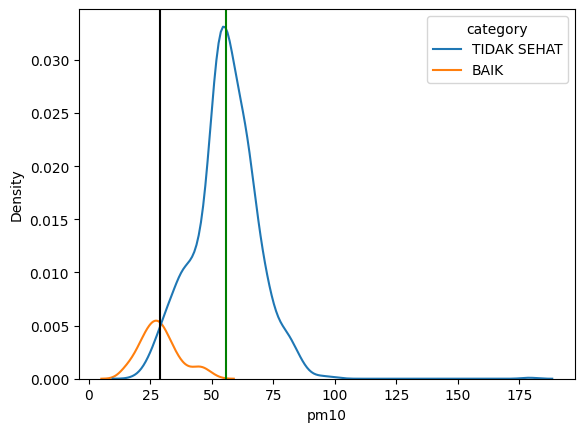

In [14]:
# pm10 column distribution.
sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "pm10",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["pm10"].mean(), 0, 1, color='g')
plt.axvline(dataset_baik["pm10"].mean(), 0, 1, color='k')
plt.show()

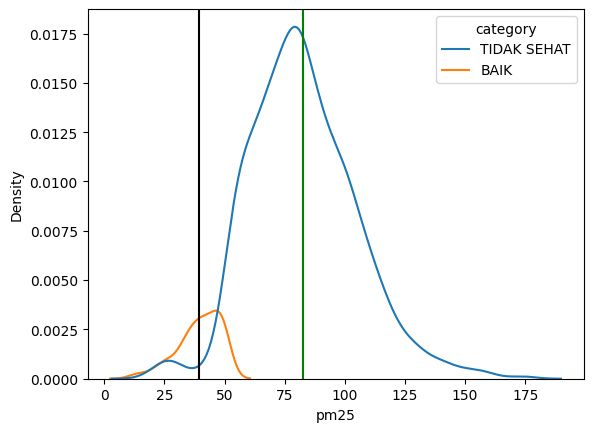

In [15]:
# pm25 column distribution.
sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "pm25",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["pm25"].mean(), 0, 1, color='g')
plt.axvline(dataset_baik["pm25"].mean(), 0, 1, color='k')
plt.show()

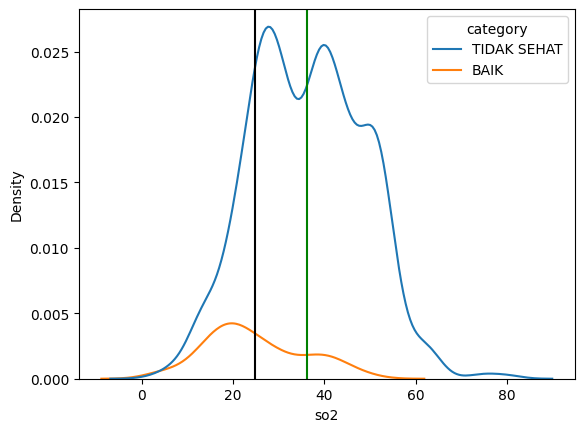

In [16]:
# so2 column distribution.
sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "so2",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["so2"].mean(), 0, 1, color='g')
plt.axvline(dataset_baik["so2"].mean(), 0, 1, color='k')
plt.show()

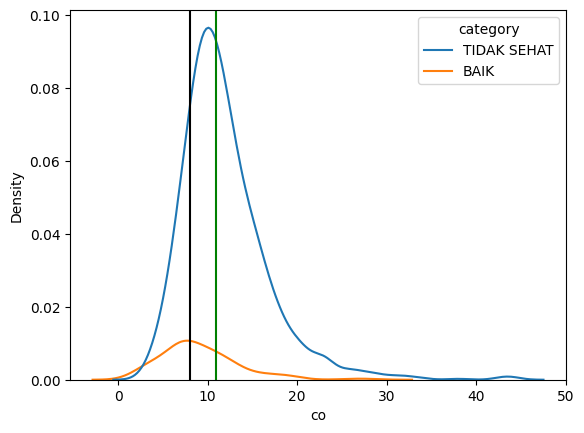

In [17]:
# co column distribution.
sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "co",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["co"].median(), 0, 1, color='g')
plt.axvline(dataset_baik["co"].median(), 0, 1, color='k')
plt.show()

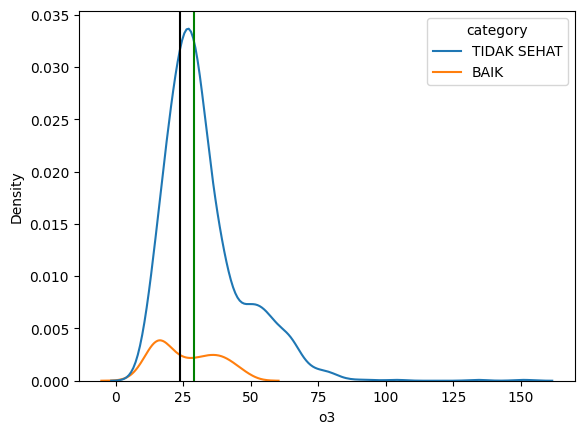

In [18]:
# o3 column distribution.
sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "o3",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["o3"].median(), 0, 1, color='g')
plt.axvline(dataset_baik["o3"].median(), 0, 1, color='k')
plt.show()

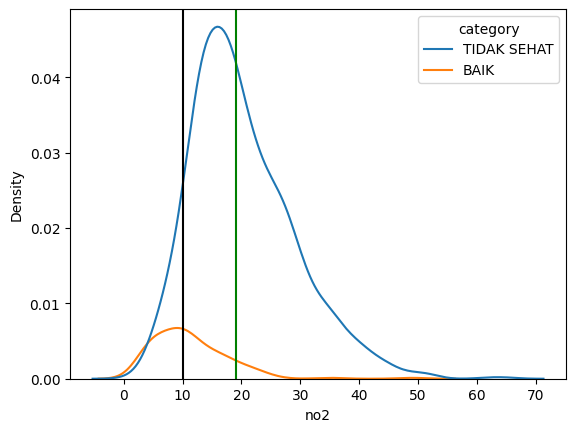

In [19]:
# no2 column distribution.
sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "no2",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["no2"].median(), 0, 1, color='g')
plt.axvline(dataset_baik["no2"].median(), 0, 1, color='k')
plt.show()

Let's check the correlation.

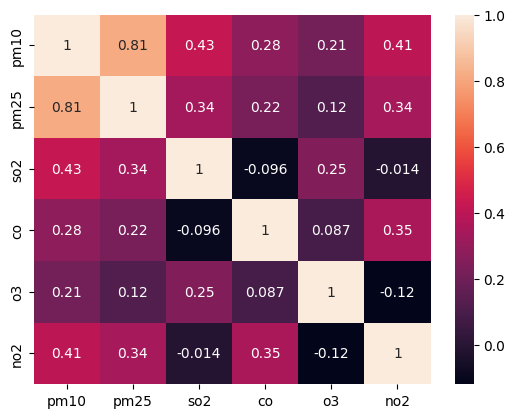

In [20]:
# Pearson Correlation.
sns.heatmap(
    dataset.corr(numeric_only=True),
    annot=True
)
plt.show()

### **3.5. Hypothesis Test**
---
T-Test (to check mean between 2 variables)

**Note:**
- $h_{0}$ (null hypothesis): mean of class 0 == mean of class 1.
- $h_{1}$ (alternative hypothesis): mean of class 0 != mean of class 1.
- $h_{0}$ and $h_{1}$ is mutually exclusive (if $h_{0}$ is true, $h_{1}$ is false, and vice versa).
- The goal of the test is to determine whether to reject the $h_{0}$.

In [21]:
# pm10 t-value.
scs.ttest_ind(
    dataset_baik[dataset_baik["pm10"].isnull() != True].pm10,
    dataset_tidak_baik[dataset_tidak_baik["pm10"].isnull() != True].pm10
)

TtestResult(statistic=np.float64(-24.05704177644637), pvalue=np.float64(2.2007663678295355e-107), df=np.float64(1406.0))

In [22]:
# t-critical for alpha=0.05 and dof=n-2
scs.t.ppf(0.05, df=(len(dataset) - 2))

np.float64(-1.6459066313849764)

**Insights:**
- If $t_{value} < t_{critical}$ and $p_{value} < 0.05$, then $h_{0}$ is rejected.
- Summary: pm10 mean between class 0 and class 1 is statistically significant.

In [23]:
# pm25 t-value.
scs.ttest_ind(
    dataset_baik[dataset_baik["pm25"].isnull() != True].pm25,
    dataset_tidak_baik[dataset_tidak_baik["pm25"].isnull() != True].pm25
)

TtestResult(statistic=np.float64(-20.21188309759663), pvalue=np.float64(8.996331865982244e-80), df=np.float64(1379.0))

In [24]:
# so2 t-value.
scs.ttest_ind(
    dataset_baik[dataset_baik["so2"].isnull() != True].so2,
    dataset_tidak_baik[dataset_tidak_baik["so2"].isnull() != True].so2
)

TtestResult(statistic=np.float64(-10.852715854407101), pvalue=np.float64(2.205179615331547e-26), df=np.float64(1372.0))

In [25]:
# co t-value.
scs.ttest_ind(
    dataset_baik[dataset_baik["co"].isnull() != True].co,
    dataset_tidak_baik[dataset_tidak_baik["co"].isnull() != True].co
)

TtestResult(statistic=np.float64(-6.685066923393782), pvalue=np.float64(3.294629003147696e-11), df=np.float64(1436.0))

In [26]:
# o3 t-value.
scs.ttest_ind(
    dataset_baik[dataset_baik["o3"].isnull() != True].o3,
    dataset_tidak_baik[dataset_tidak_baik["o3"].isnull() != True].o3
)

TtestResult(statistic=np.float64(-5.255840461027113), pvalue=np.float64(1.7002243453627037e-07), df=np.float64(1410.0))

In [27]:
# no2 t-value.
scs.ttest_ind(
    dataset_baik[dataset_baik["no2"].isnull() != True].no2,
    dataset_tidak_baik[dataset_tidak_baik["no2"].isnull() != True].no2
)

TtestResult(statistic=np.float64(-11.902440585156517), pvalue=np.float64(3.2151372843906206e-31), df=np.float64(1434.0))

### **3.6. Imbalanced Label Check**

In [28]:
# Check the proportion of the label.
dataset["category"].value_counts(normalize=True)

category
SEDANG         0.720000
TIDAK SEHAT    0.175862
BAIK           0.104138
Name: proportion, dtype: float64

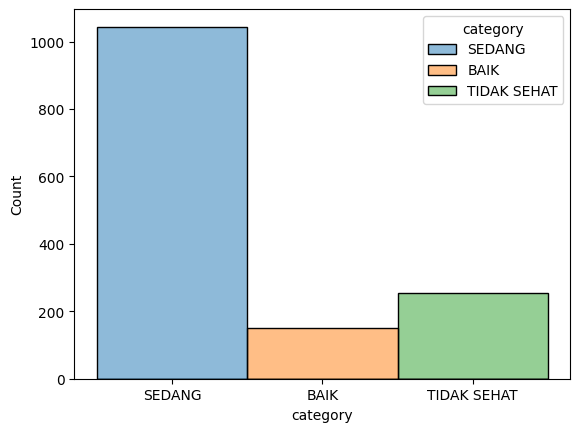

In [29]:
sns.histplot(
    data = dataset,
    x = "category",
    hue="category"
)
plt.show()

### **3.7. Outliers Check**

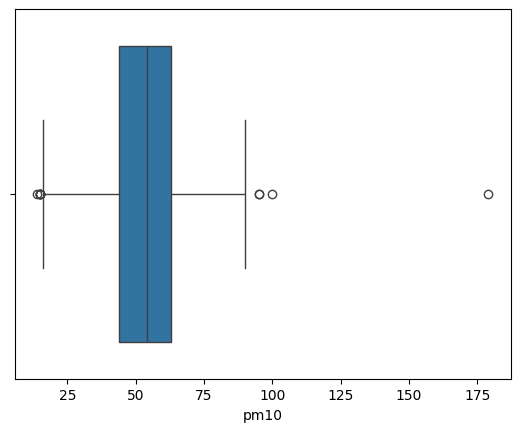

In [30]:
# pm10 boxplot.
sns.boxplot(
    data = dataset,
    x = "pm10"
)
plt.show()

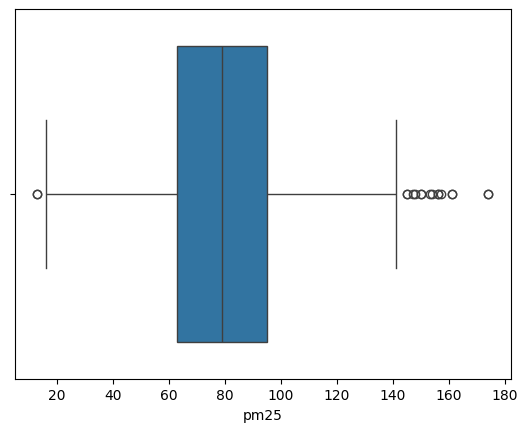

In [31]:
# pm25 boxplot.
sns.boxplot(
    data = dataset,
    x = "pm25"
)
plt.show()

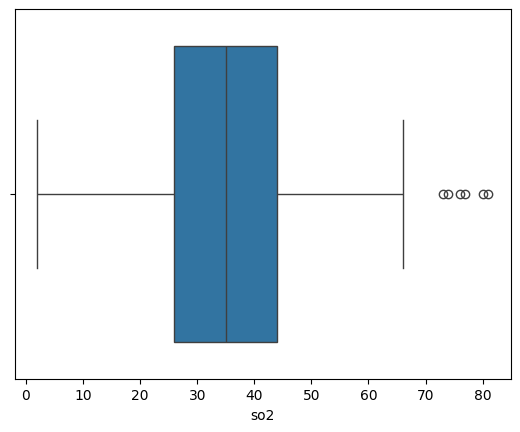

In [32]:
# so2 boxplot.
sns.boxplot(
    data = dataset,
    x = "so2"
)
plt.show()

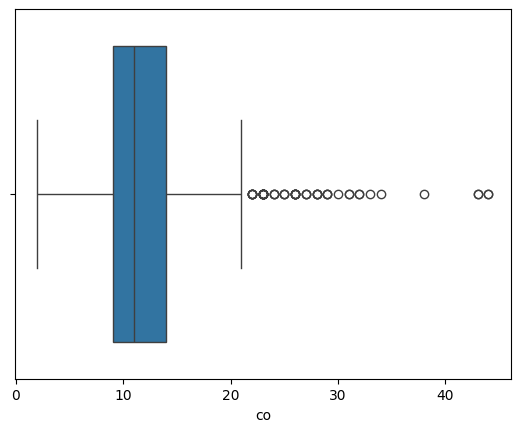

In [33]:
# co boxplot.
sns.boxplot(
    data = dataset,
    x = "co"
)
plt.show()

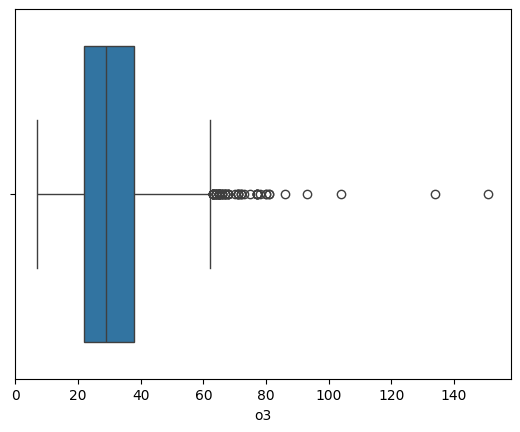

In [34]:
# o3 boxplot.
sns.boxplot(
    data = dataset,
    x = "o3"
)
plt.show()

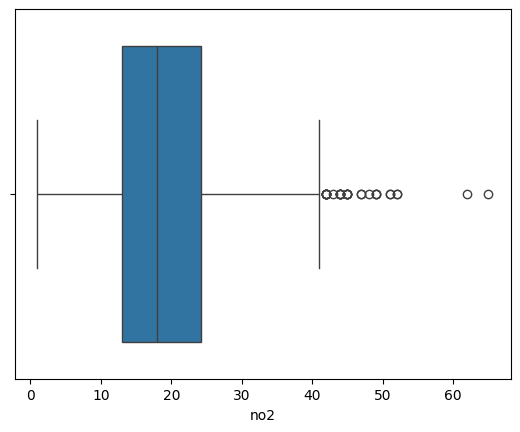

In [35]:
# no2 boxplot.
sns.boxplot(
    data = dataset,
    x = "no2"
)
plt.show()

**Summary:**
1. Missing Value Handling
    - pm10 and pm25 : class mean
    - so2 : mean
    - co, o3, and no2 : median
2. Join label SEDANG and TIDAK SEHAT into TIDAK BAIK
3. Label balancing BAIK and TIDAK BAIK
4. Outliers removal